#  Agents based Dialogic & Deliberative


## Problem Statement

As an example of deliberative decision making and real-world application, the use case is modelled for [Economic Development Board (EDB, Singapore)](https://www.edb.gov.sg/).

This problem statement draws its inspiration from the original SG AI Trailblazer jumpstart project for EDB (Singapore) that aimed to enable EDB's house view on how to engage companies and encourage investment in strategic verticals. EDB wants to prepare its case to attract investments from MNCs into Singapore by providing in-depth understanding of companies and trends across the industries and regions.

This notebook takes simulates a deliberation between 2 agents for the following specific subject:

```
Should the Economic Development Board (EDB), Singapore undertake investment promotions for Pfizer in Singapore ?
Critique based on Pfizer's recent financial performance data and company strategy.

You may refer to this website: https://www.sec.gov/Archives/edgar/data/78003/000007800321000038/pfe-20201231.htm.
Cite reference data with sources where applicable.

```

The topic above has been kept specific to Pfizer Inc. for the purposes of simplicity and non-trivial demonstration of the concept withing current capstone project context.

The approach of Adversarial Agent based Dialogic & Deliberation can be extended beyond two agents and wider topics, e.g. in corporate strategy, for instance, agents can represent various stakeholder interests, debating the potential impacts of business decisions on different segments like customers, employees, and shareholders. In policy-making, agents can simulate diverse societal viewpoints, ensuring that policies are robustly scrutinized from multiple angles, thus enhancing their effectiveness and public acceptance. In educational settings, this approach can stimulate critical thinking and engagement, offering students a platform to analyze and interact with different perspectives on academic subjects.



## Solution Approach

A motion / deliberation topic is defined, and two adversarial agents are created. The adversarial agents take turns to deliberate 'for' and 'against' the topic. After a finite number of turns, the arguments presented by both the agents are examined by jury and the winning agent is proclaimed. The jury agent also identifies any missing information, infactualities and additional considerations.

## Solution

The solution models the conversations / deliberations as a directed graph flow, with conditional edges. Cycles are defined as to-fro turn based deliberation between the agents. Cycles are exited when the max number of deliberation terms are completed.

### Setup

In [1]:
# Install deps with frozen version
# !pip install -q google-generativeai==0.5.0 langchain-google-genai==1.0.2 langchain==0.1.16 langgraph==0.0.36 
!pip install -q google-generativeai==0.5.0 google-cloud-aiplatform[rapid_evaluation]==1.48 pandas nest_asyncio

In [ ]:
# For Graph vizualization
# !apt install -y -q libgraphviz-dev
!pip install -q pygraphviz
%pip install langgraph

In [3]:
# # Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

In [4]:
import os
from datetime import datetime
import logging
from tqdm import tqdm
import nest_asyncio
import warnings

from typing import Dict, TypedDict, List, Optional

from langchain_core.output_parsers import CommaSeparatedListOutputParser
    # Import a LangChain output parser for handling comma-separated lists

from langgraph.graph import StateGraph, END
    # Import core components for building workflow graphs from the LangChain's "LangGraph" library

import google.generativeai as genai

from google.generativeai.types import HarmCategory, HarmBlockThreshold


/opt/conda/envs/r/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configurations

In [6]:
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)
nest_asyncio.apply()
warnings.filterwarnings("ignore")

# API Key Setup
# os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')  # Retrieve a stored Google API key from user data
os.environ['LANGCHAIN_API_KEY'] = "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"


# userdata.get("LANGCHAIN_API_KEY")  # Retrieve a stored LangChain API key

# Run ID Generation
current_runId = str(int(datetime.now().timestamp() * 1000))  # Generate a unique ID based on the current timestamp (easier to sort)
print(f"current run ID = {current_runId}")

# LangChain Configuration
langsmith_proj = f"A2D2_{current_runId}"
os.environ["LANGCHAIN_PROJECT"] = langsmith_proj  # Set the project name, including the run ID
os.environ['LANGCHAIN_TRACING_V2'] = 'true'  # Enable detailed tracing for debugging
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'  # Set the API endpoint for LangChain interaction

print(f"Langsmith Project ID: {langsmith_proj}")

current run ID = 1718089445691
Langsmith Project ID: A2D2_1718089445691


In [7]:
import socket
import re

PROJECT_ID = !(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]

SVC_ACC = !(gcloud config get-value core/account)
SVC_ACC = SVC_ACC[0]

PROJECT_NUMBER=str(re.search(r'\d+', SVC_ACC).group())

LOCATION="us-central1"

UNIQUE_PREFIX = socket.gethostname()
UNIQUE_PREFIX = re.sub('[^A-Za-z0-9]+', '', UNIQUE_PREFIX)

BUCKET_NAME = f"{PROJECT_ID}-{UNIQUE_PREFIX}-{LOCATION}"

BUCKET_URI = f"gs://{BUCKET_NAME}"  # @param {type:"string"}

! gcloud config set project $PROJECT_ID
# ! gcloud storage buckets create {BUCKET_URI} --project={PROJECT_ID} --location={LOCATION}
! mkdir output

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=BUCKET_URI)
# Set the project id
! gcloud config set project {PROJECT_ID}

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

Updated property [core/project].
Creating gs://my-project-0004-346516-pytorch112kagglewbi-us-central1/...
ERROR: (gcloud.storage.buckets.create) HTTPError 409: Your previous request to create the named bucket succeeded and you already own it.
Updated property [core/project].


### General Initializations

In [8]:
# genai.configure(api_key=os.environ['GOOGLE_API_KEY'])
    # Configure the Google AI interface with your API key (fetched from environment variables).

# for m in genai.list_models():
#     # Iterate through the available models returned by the Google AI service.
#   if 'generateContent' in m.supported_generation_methods:
#       # Check if the current model supports the 'generateContent' method.
#     print(m.name)  # If it does, print the model's name.

In [23]:
retrieved_result = """

Question : 'Is bundling discount available?'
answer : 'Bundling Discount is only offered to vPost SG Customers only. The lowest-priced package will automatically be selected as the first Package to provide maximum discount and value. Discount will apply only on the second and subsequent packages Bunding discount applies when customer ship multiple package in one shipment.' 

"""

In [86]:
from vertexai.preview.vision_models import ImageGenerationModel
from langchain_google_vertexai import ChatVertexAI
from vertexai.generative_models import GenerativeModel, Part, FinishReason
import vertexai.preview.generative_models as generative_models

import uuid, os

# Initialize Gemini LLM model = gemini-1.5-flash-001

vertexai.init(project=PROJECT_ID, location="us-central1")
model = GenerativeModel(
"gemini-1.5-pro-001",
)

llm = model
# responses = model.generate_content(
#   [text1],
#   generation_config=generation_config,
#   safety_settings=safety_settings,
#   stream=True,
# )


text1 = retrieved_result

generation_config = {
"max_output_tokens": 5147,
"top_p": 0.95,
}

safety_settings = {
generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
}

### Deliberation Setup

In [87]:
# Define the deliberation topic.

# This is an example, where an external link was included.


DELIBERATION_TOPIC = "Should the Economic Development Board (EDB), Singapore undertake investment promotions for Pfizer in Singapore ? Critique based on Pfizer's recent financial performance data and company strategy. You may refer to this website: https://www.sec.gov/Archives/edgar/data/78003/000007800321000038/pfe-20201231.htm. Cite reference data with sources where applicable."  # @param {type:"string"}

In [88]:
# number of rounds of discussions / exchanges that should take place.
MAX_DELIBERATION_ROUNDS = "10" # @param {type:"string"}

# the number of sentences with which an agent may respond with (control verbosity, suggested, 1 or 2)
MAX_RESPONSE_LENGTH = 2 #@param {type:"string"}

In [105]:
output = llm.generate_content("I am organizing a discussion on {}. \
What would be the opposing sides called? \
Output just the team names and nothing else as comma separated list".format(DELIBERATION_TOPIC),
                              generation_config=generation_config, safety_settings=safety_settings).text

# Prompt the LLM to generate opposing agent names for the discussion topic, requesting a comma-separated format.

agents = CommaSeparatedListOutputParser().parse(output)[0:2]  # Extract the first two agent names from the comma-separated list.

# Use the output parser to extract the agent names from the LLM's response.

print(agents)  # Display the parsed agent names.

['Team Pfizer', 'Team No Pfizer']


### Deliberation Graph Design

#### Define node shared attributes

A class containing the state variables for the discussion graph nodes is defined below. Some of the variables may not be applicable for all nodes (but are included for the purposes of future extensibility).

In [106]:
class DeliberationGraphState(TypedDict):
    """
    This class models the evolving state of a deliberation. Not all attributes need to be present at every stage.

    Attributes:
        topic (str): Ensures the dialogue stays focused on the primary deliberation topic. To allow for dynamically injecting sub-topics.

        classification (Optional[str]):  The sentiment classification of the most recent response (e.g., 'positive', 'negative', etc.).

        history (Optional[str]): A cumulative record of the conversation's dialogue.

        current_response (Optional[str]): The latest response or argument made.

        count (Optional[int]): A counter indicating the number of exchanges or turns in the conversation.

        outcomes (Optional[str]): A summary of the deliberation's outcome, including the declared winner and additional notes or observations.

        opening (Optional[str]): An optional introductory or welcome message to initiate the deliberation.

        supporting_evidence (str): A piece of evidence or source material supporting the current_response.

        argument_type (str): Categorizes the argument style (e.g., 'fact-based', 'appeal to emotion', 'logical fallacy').

        intent (str): Captures the intended action of the current_response (e.g., 'argue', 'question', 'concede').

        keywords (List[str]): Important keywords that summarize the content of the current_response.

        confidence (float): A confidence score (between 0 and 1) assigned by the LLM, indicating how certain it is about its classification, argument generation, or results.

        timestamp (datetime): The time the current_response was generated.

        agents (List[str]): A list of agent names.
    """

    topic: Optional[str]
    classification: Optional[str]
    history: Optional[str]
    current_response: Optional[str]
    count: Optional[int]
    outcomes: Optional[str]

    opening: Optional[str]
    supporting_evidence: Optional[str]
    argument_type: Optional[str]
    intent: Optional[str]
    keywords: Optional[List[str]]
    confidence: Optional[float]
    timestamp: Optional[datetime]
    agents: Optional[List[str]]

    def __init__(self):
      self.topic = DELIBERATION_TOPIC
      self.timestanp = datetime.now()
      self.agents = agents



In [91]:
# Custom Exceptions

class InvalidTopicError(Exception):
    """Raised when an invalid or unsupported topic is provided."""

class MissingHistoryError(Exception):
    """Raised when the 'history' attribute is required but missing."""

class ConfidenceThresholdError(Exception):
    """Raised when the LLM's confidence falls below a specified threshold."""


#### Set preliminary context for agents

In [92]:
# Define the default starting context for the agents.

agent_prelim_context = "You are in support of {}.  \
You're currently engaged in a discussion with {}, discussing {}. \
Here's what has been said so far: \n{}\n. \
Now, present a new argument in favor of {}, directly addressing {}. \
Dont repeat your previous arguments. Keep your response concise and to max " + str(MAX_RESPONSE_LENGTH) + " sentences."

#### Define graph nodes

In [93]:
def classify(text_in):
    """Classifies the sentiment of a question using a large language model.

    Args:
        text_in (str): The input text to classify.
        agents (List[str]): A list of agent names.
    Returns:
        str: The predicted sentiment class (e.g., 'positive' or 'negative').
    """

    return llm.generate_content(
        "classify the sentiment of input as {} or {}. Output just the class. Input:{}".format(
            "_".join(agents[0].split(" ")), "_".join(agents[1].split(" ")), text_in
        ), generation_config=generation_config, safety_settings=safety_settings
    ).text.strip()


def assign_argument_type(text_in: str) -> str:
    """
    Classifies the given text into one of three argument types: 'fact-based',
    'appeal to emotion', or 'logical fallacy'.

    Args:
        text_in (str): The text input to be classified.

    Returns:
        str: The assigned argument type ('fact-based', 'appeal to emotion', or 'logical fallacy').

    Raises:
        Exception: If the underlying LLM encounters an error during classification.
    """

    try:
        result = llm.generate_content(
            "classify the input as 'fact-based', 'appeal to emotion' or 'logical fallacy'. \
            Output just one class. Input:{}".format(
                text_in
            ), generation_config=generation_config, safety_settings=safety_settings
        ).text.strip()
        return result
    except Exception as e:
        raise Exception(f"Error during argument type classification: {e}")



def classify_response_node(state):
    """Extracts the current response from the state and classifies its sentiment.

    Args:
        state (dict): The conversational state, containing at least the 'current_response' key.

    Returns:
        dict: Updated state with the 'classification' key added.
    """

    classification = classify(text_in=state.get("current_response"))

    return {"classification": classification}


def initiate_deliberation_node(state):
    """Creates a init message for the deliberation, specifying the topic and opposing sides.
    This be used to assign any global state variables to the conversations.

    Args:
        state (dict): The conversational state (unused in this case).

    Returns:
        dict: A dictionary containing a 'opening/greeting' message.
    """

    return {
        "opening": "Welcome! Today's deliberation will feature {} versus {}".format(
            agents[0], agents[1]
        )
    }


def agent_favor(state):
    """Generates a counter argument supporting the agent's favored side in the deliberatio.
    Uses the past conversations and and last response by the other agent.

    Args:
        state (dict): The conversational state.

    Returns:
        dict: Updated state with 'history', 'current_response', and 'count'.
    """

    try:
        summary = state.get("history", "").strip()
        current_response = state.get("current_response", "").strip()

        if summary == "Nothing":
            prompt = agent_prelim_context.format(
                agents[0], agents[1], DELIBERATION_TOPIC, "Nothing", agents[0], "Nothing"
            )
        else:
            prompt = agent_prelim_context.format(
                agents[0],
                agents[1],
                DELIBERATION_TOPIC,
                summary,
                agents[0],
                current_response,
            )

        argument = agents[0] + ": " + llm.generate_content(prompt,
                                                           generation_config=generation_config,
                                                           safety_settings=safety_settings).text
        
        print('argument pose',argument)
        return {
            "history": summary + "\n" + argument,
            "current_response": argument,
            "count": state.get("count", 0) + 1,  # Handle missing 'count' key
        }

    except Exception as e:  # Catch a broad range of exceptions
        # Handle the exception based on your needs:
        # 1. Log the error for debugging
        print(f"Error in agent_favor: {e}")

        # 2. Return a default or fallback response
        return {
            "history": state.get("history", ""),
            "current_response": "Error generating response. Please try again later.",
            "count": state.get("count", 0),
        }



def agent_oppose(state):
    """Generates a counter argument supporting the agent's side (opposing the deliberation topic).
    Uses the past conversations and and last response by the other agent.

    Args:
        state (dict): The conversational state.

    Returns:
        dict: Updated state with 'history', 'current_response', and 'count'.
    """

    try:
        summary = state.get("history", "").strip()
        current_response = state.get("current_response", "").strip()

        prompt = agent_prelim_context.format(
            agents[1], agents[0], DELIBERATION_TOPIC, summary, agents[1], current_response
        )
        argument = agents[1] + ": " + llm.generate_content(prompt,
                                                           generation_config=generation_config,
                                                           safety_settings=safety_settings).text

        print('argument neg',argument)

        return {
            "history": summary + "\n" + argument,
            "current_response": argument,
            "count": state.get("count", 0) + 1,  # Handle missing 'count' key
        }

    except Exception as e:
        # Handle the exception (log, fallback response, etc.)
        print(f"Error in agent_oppose: {e}")
        return {
            "history": state.get("history", ""),
            "current_response": "Error generating response. Please try again later.",
            "count": state.get("count", 0),
        }



def outcome(state):
    """Provides a deliberation summary, declares a winner,
    and notes issues once the maximum deliberation rounds limit is reached.

    Args:
        state (dict): The conversational state.

    Returns:
        dict: A dictionary containing the 'results' text.
    """

    try:
        summary = state.get("history", "").strip()  # Handle missing 'history' key

        prompt = "Summarize the conversation and judge who won the discussion. \
        No ties are allowed. Also, highlight any missing information shared \
        and/or additional considerations under 'additional notes'. \
        Conversation:{}".format(summary)

        outcome_text = llm.generate_content(prompt,
                                            generation_config=generation_config,
                                            safety_settings=safety_settings).text
        return {"outcomes": outcome_text}

    except Exception as e:
        # Handle the exception (log, fallback response, etc.)
        print(f"Error in outcome: {e}")
        return {"outcome": "Error generating outcomes. Please try again later."}



#### Define graph edges and connected components

Add graph's edges and associated conditions. Essentially, how the next agent is chosen and / or how the deliberation ends.

In [94]:
def decide_next_agent_turn(state):
    """Chooses which agent goes next based on the last response's sentiment analysis.

    Args:
        state (dict): The conversational state containing the 'classification' key.

    Returns:
        str: 'agent_favor' if the sentiment matches the first class, otherwise 'agent_oppose'.
    """

    return "agent_oppose" if state.get('classification')=='_'.join(agents[0].split(' ')) else "agent_favor"



def check_num_rounds(state, max_deliberation_rounds=MAX_DELIBERATION_ROUNDS):
    """Determines if the deliberation should end based on the number of exchanges.

    Args:
        state (dict): The conversational state containing the 'count' key.
        max_deliberation_rounds (int, optional): Maximum allowed conversational exchanges (default: 10).

    Returns:
        str: 'outcome' if the turn count has reached the maximum, otherwise 'classify_response'.
    """

    return "outcome" if state.get("count") == MAX_DELIBERATION_ROUNDS else "classify_response"

#### Finalize deliberation graph workflow

Tie together all the nodes and edges as defined above, including the entry / starting and ends nodes.

In [95]:
def create_deliberation_workflow(dgraph):

  # Define nodes to structure the deliberation workflow:

  # Input Analysis:
  dgraph.add_node("classify_response", classify_response_node)  # Classify the sentiment of each response

  # Deliberation Setup:
  dgraph.add_node("initiate_deliberation", initiate_deliberation_node)  # Generate an opening message

  # Argument Exchange:
  dgraph.add_node("agent_favor", agent_favor)  # Generate arguments in favor of the agent's side
  dgraph.add_node("agent_oppose", agent_oppose)  # Generate arguments opposing the agent's side

  # Outcome Evaluation:
  dgraph.add_node("outcome", outcome)  # Summarize the deliberation and determine the winner

  # Sentiment-Driven Branching
  dgraph.add_conditional_edges(
      "classify_response",
      decide_next_agent_turn,  # Function to determine the which agent goes next based on the sentiment of the last agent's response
      {
          "agent_favor": "agent_favor",
          "agent_oppose": "agent_oppose"
      }
  )

  # Check No. of Deliberation Rounds (From 'agent_favor')
  dgraph.add_conditional_edges(
      "agent_favor",
      check_num_rounds,  # Function to assess if the number of deliberation rounds limit is reached
      {
          "outcome": "outcome",  # Transition to outcome calculation if the limit is met
          "classify_response": "classify_response"  # Continue with argument exchange if not
      }
  )

  # Check No. of deliberation rounds (From 'agent_oppose')
  dgraph.add_conditional_edges(
      "agent_oppose",
      check_num_rounds,  # (Same functionality as above)
      {
          "outcome": "outcome",
          "classify_response": "classify_response"
      }
  )

  # === Workflow Initialization ===

  dgraph.set_entry_point("initiate_deliberation")  # Designate the starting point for the deliberation flow

  dgraph.add_edge('initiate_deliberation', "agent_favor")  # After initiation, transition to the first argument (agent's side)

  # === Workflow Termination ===
  dgraph.add_edge('outcome', END)  # Mark the 'outcome' node as the endpoint of the workflow

  return dgraph

### Run Deliberation

In [96]:
# Save / Persist tghe state of the graph at point and resume from there
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

#### Compile the graph and workflow

In [97]:
def compile_graph():
    """
    Compiles the Deliberation Graph into an executable LangChain Runnable,
    handling potential errors during the process.

    This function takes the current state of the Deliberation Graph and transforms it
    into a runnable workflow using LangChain. The compiled workflow can then be
    executed to perform reasoning or decision-making processes based on the graph's
    structure and content.

    Returns:
        LangChainRunnable: An executable representation of the deliberation workflow.

    Raises:
        Exception: If an error occurs during graph state capture or workflow compilation.
    """

    try:
        dgraph = StateGraph(DeliberationGraphState)  # Capture current graph state
        app = create_deliberation_workflow(dgraph).compile(checkpointer=memory)
        return app
    except Exception as e:
        raise Exception(f"Error compiling Deliberation Graph: {e}")


In [98]:
# Start Deliberation
import uuid
from langsmith import traceable

deliberation_id = str(uuid.uuid4())

@traceable(
    run_type="llm",
    run_id=deliberation_id,
    name="Dialogic Deliberative Decision Making",
    tags=["colab", "subhadipmitra@google.com"],
    metadata={
        "deliberation_id": deliberation_id,
        "deliberation_topic": DELIBERATION_TOPIC,
        "thread_id": 1,
        "recursion_limit": 15,
    }
)
def run_deliberation(app):
    config = {'configurable': {'session_id': deliberation_id, 'thread_id': 1}, 'recursion_limit' : 500}
    inputs = {'count': 0, 'history': 'Nothing', 'current_response': ''}


  # Run the workflow
  # deliberation = app.invoke(inputs, config)
    deliberation = app.invoke(inputs, config=config) # or a higher value
    
    return deliberation

In [99]:
app = compile_graph()

#### Preview the compiled graph

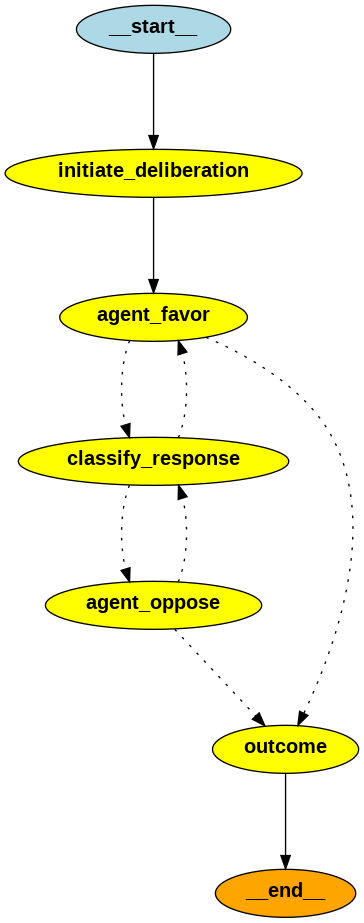

In [100]:
from IPython.display import Image

Image(app.get_graph().draw_png())

#### Run Current Deliberation

In [101]:
current_deliberation = run_deliberation(app)

ResourceExhausted: 429 Quota exceeded for aiplatform.googleapis.com/generate_content_requests_per_minute_per_project_per_base_model with base model: gemini-1.5-pro. Please submit a quota increase request. https://cloud.google.com/vertex-ai/docs/generative-ai/quotas-genai.

#### Deliberation Log

In [102]:
print(current_deliberation['history'])

NameError: name 'current_deliberation' is not defined

#### Deliberation Outcome

Below is the interpretation of the conversation between the agents

In [103]:
from IPython.display import display, Markdown

display(Markdown(current_deliberation['outcomes']))

NameError: name 'current_deliberation' is not defined

## Tracing and Evaluations

### LangSmith Tracing

In [104]:
run_id="0b1c77d1-321c-42e7-abac-bc5001fa19de"

from langsmith import Client

client = Client()
run = client.read_run(run_id)
print(run.url)

LangSmithNotFoundError: Resource not found for https://api.smith.langchain.com/runs/0b1c77d1-321c-42e7-abac-bc5001fa19de. HTTPError('404 Client Error: Not Found for url: https://api.smith.langchain.com/runs/0b1c77d1-321c-42e7-abac-bc5001fa19de', '{"detail":"Run not found"}')

[langsmith run screenshot](https://drive.google.com/file/d/1ZFlY2fOVGIsO5Hc9qV7xYYkfQB2B4uWQ/view)

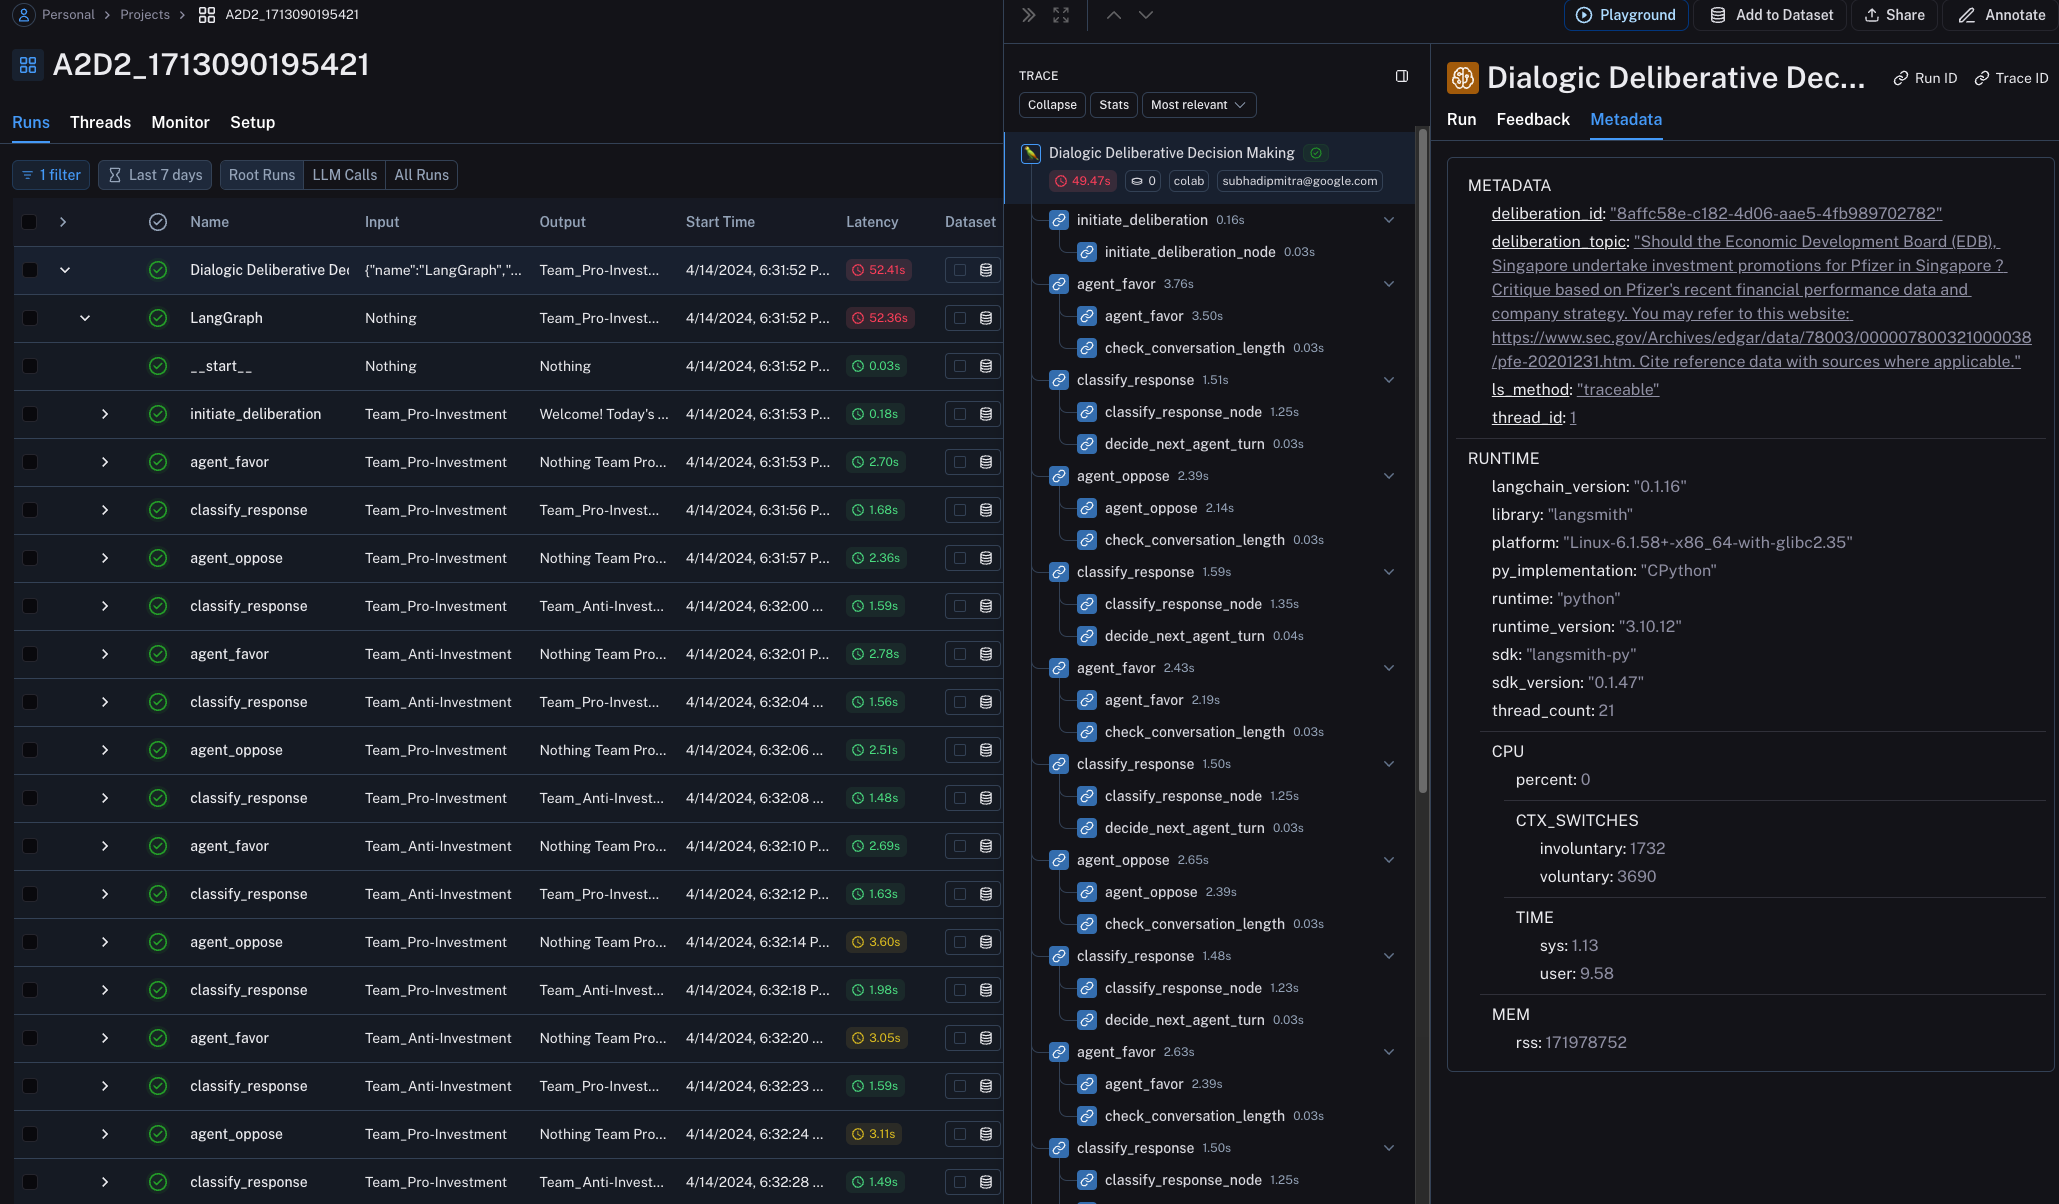


### Rapid Evaluations

In [ ]:
import inspect
import random
import string
from IPython.display import display, Markdown, HTML
import plotly.graph_objects as go


# Main
import vertexai
import pandas as pd
from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel, HarmCategory, HarmBlockThreshold

from vertexai.preview.evaluation import (
    EvalTask,
    PromptTemplate,
    CustomMetric,
    make_metric,
)


def generate_uuid(length: int = 8) -> str:
    """Generate a uuid of a specifed length (default=8)."""
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


def print_doc(function):
    print(f"{function.__name__}:\n{inspect.getdoc(function)}\n")


def display_eval_report(eval_result, metrics=None):
    """Display the evaluation results."""

    title, summary_metrics, report_df = eval_result
    metrics_df = pd.DataFrame.from_dict(summary_metrics, orient="index").T
    if metrics:
        metrics_df = metrics_df.filter(
            [
                metric
                for metric in metrics_df.columns
                if any(selected_metric in metric for selected_metric in metrics)
            ]
        )
        report_df = report_df.filter(
            [
                metric
                for metric in report_df.columns
                if any(selected_metric in metric for selected_metric in metrics)
            ]
        )

    # Display the title with Markdown for emphasis
    display(Markdown(f"## {title}"))

    # Display the metrics DataFrame
    display(Markdown("### Summary Metrics"))
    display(metrics_df)

    # Display the detailed report DataFrame
    display(Markdown(f"### Report Metrics"))
    display(report_df)


def display_explanations(df, metrics=None, n=1):
    style = "white-space: pre-wrap; width: 800px; overflow-x: auto;"
    df = df.sample(n=n)
    if metrics:
        df = df.filter(
            ["instruction", "context", "reference", "completed_prompt", "response"]
            + [
                metric
                for metric in df.columns
                if any(selected_metric in metric for selected_metric in metrics)
            ]
        )

    for index, row in df.iterrows():
        for col in df.columns:
            display(HTML(f"<h2>{col}:</h2> <div style='{style}'>{row[col]}</div>"))
        display(HTML("<hr>"))


def plot_radar_plot(eval_results, metrics=None):
    fig = go.Figure()

    for eval_result in eval_results:
        title, summary_metrics, report_df = eval_result

        if metrics:
            summary_metrics = {
                k: summary_metrics[k]
                for k, v in summary_metrics.items()
                if any(selected_metric in k for selected_metric in metrics)
            }

        fig.add_trace(
            go.Scatterpolar(
                r=list(summary_metrics.values()),
                theta=list(summary_metrics.keys()),
                fill="toself",
                name=title,
            )
        )

    fig.update_layout(
        polar=dict(radialaxis=dict(visible=True, range=[0, 5])), showlegend=True
    )

    fig.show()


def plot_bar_plot(eval_results, metrics=None):
    fig = go.Figure()
    data = []

    for eval_result in eval_results:
        title, summary_metrics, _ = eval_result
        if metrics:
            summary_metrics = {
                k: summary_metrics[k]
                for k, v in summary_metrics.items()
                if any(selected_metric in k for selected_metric in metrics)
            }

        data.append(
            go.Bar(
                x=list(summary_metrics.keys()),
                y=list(summary_metrics.values()),
                name=title,
            )
        )

    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(barmode="group")
    fig.show()


def print_aggregated_metrics(job):
    """Print AutoMetrics"""

    rougeLSum = round(job.rougeLSum, 3) * 100
    display(
        HTML(
            f"<h3>The {rougeLSum}% of the reference summary is represented by LLM when considering the longest common subsequence (LCS) of words.</h3>"
        )
    )


def print_autosxs_judgments(df, n=3):
    """Print AutoSxS judgments in the notebook"""

    style = "white-space: pre-wrap; width: 800px; overflow-x: auto;"
    df = df.sample(n=n)

    for index, row in df.iterrows():
        if row["confidence"] >= 0.5:
            display(
                HTML(
                    f"<h2>Document:</h2> <div style='{style}'>{row['id_columns']['document']}</div>"
                )
            )
            display(
                HTML(
                    f"<h2>Response A:</h2> <div style='{style}'>{row['response_a']}</div>"
                )
            )
            display(
                HTML(
                    f"<h2>Response B:</h2> <div style='{style}'>{row['response_b']}</div>"
                )
            )
            display(
                HTML(
                    f"<h2>Explanation:</h2> <div style='{style}'>{row['explanation']}</div>"
                )
            )
            display(
                HTML(
                    f"<h2>Confidence score:</h2> <div style='{style}'>{row['confidence']}</div>"
                )
            )
            display(HTML("<hr>"))


def print_autosxs_win_metrics(scores):
    """Print AutoSxS aggregated metrics"""

    score_b = round(scores["autosxs_model_b_win_rate"] * 100)
    display(
        HTML(
            f"<h3>AutoSxS Autorater prefers {score_b}% of time Model B over Model A </h3>"
        )
    )

In [ ]:
PROJECT_ID = PROJECT_ID  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

vertexai.init(project=PROJECT_ID, location=LOCATION)

instructions = current_deliberation['history'].split("\n")[1:]

eval_dataset = pd.DataFrame(
    {
        "content": instructions,
    }
)

qa_eval_task = EvalTask(
    dataset=eval_dataset,
    metrics=["safety", "text_generation_quality"],
    experiment=f"a2d2-eval-{deliberation_id}",
)

result = qa_eval_task.evaluate(
    model=llm, experiment_run_name=f"a2d2-{deliberation_id}-eval-{generate_uuid()}"
)

In [ ]:
display_eval_report(((f"Eval Result for Deliberation ID: {deliberation_id}", result.summary_metrics, result.metrics_table)))

## Further Work

- Multiple agents, dynamically generated
- Assign dynamic agent goals (beyond a simplistic pro/oppose approaches)
- Leverage 'supporting arguments', 'confidence' to dynamically modify conversation graph.
- dynamically inject context or influence / modify the deliberation topic
- Agent deliberation positions may be augmented by continuous web search actions and other knowledge repositories.
- DSL (Domain Specific Language) for construction/manipulation of the deliberation graph